## Piezo Electric Sensor Processing Simulation Notebook.

Regular piezoelectric sensor shall produce a signal of limited energy close to dampen sine wave.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Singular Dampen Sine Wave

Below is a singular simulated wave after a hit from piezoelectric sensor sampled at the same frequency as ADC's sampling rate used within the read firmware. Additional 2% noise is added since the same behavior is seen on real piezoelectric sensor's readings. Even same batch of those sensors will have slightly different resonance frequency, however comparing their FFT does not give the required results, since cross-talking sensors will also start to osscilate on their own frequencies as well as frequencies of their neighbors.

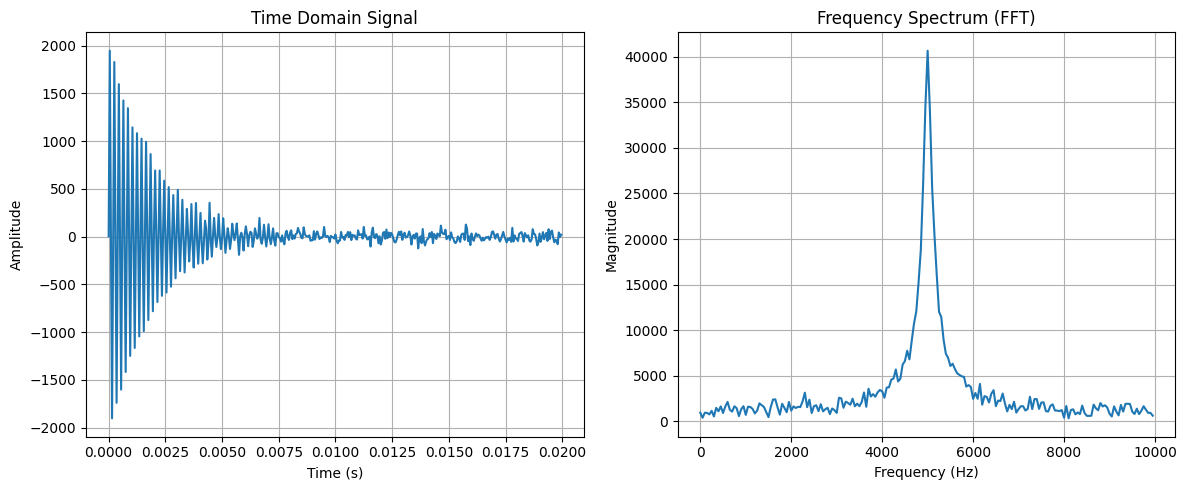

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs          = 20000              # ADC Sampling frequency of 20kHz. 
t_max       = 0.02
f           = 5000               # Hit osscilation frequency (averaged for 20mm piezos.)
decay       = 500                # Decay rate (avaraged for 20mm piezos.)
amplitude   = 2048               # ADC reads values from 0 to 4096. We shift all those values to range of -2048 to 2048
noise_level = amplitude * 0.02   # 2% of maximum amplitude

# Time vector
t = np.linspace(0, t_max, int(fs*t_max), endpoint=False)

# Damped sine wave (Piezoelectric sensor simulation.)
signal = amplitude * np.exp(-decay*t) * np.sin(2*np.pi*f*t)
signal += noise_level * np.random.randn(len(signal))    # Simulating small additional noise.

# FFT
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, 1/fs)
fft_magnitude = np.abs(fft_vals[:N//2])
fft_freqs = fft_freqs[:N//2]

# Signal plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t, signal)
plt.title("Time Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# FFT plot
plt.subplot(1,2,2)
plt.plot(fft_freqs, fft_magnitude)
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()


## Crosstalk Simulation Of All Four Piezos

Since all four piezos are basically glued to one surface that will perform mechanical oscillations, I expect cross-talks between the hit sensor and the rest of them. 3D Modeled drum structure is implemented to ensure distance of roughly 4 cm. between each sensor. Each sensors kats, and dons are placed linearly.

The main difference in their signals is expected to be the delay between each sine. We cannot use amplitude as any proper information, since each piezo sensor will provide different signals of different amplitudes, due to their internal design, the strength of hit, the length of cables and other electrical shenanigans that might occur on the PCB. Even with fast sampling rate it is very hard to find when each signal actually starts, and if they are actually crosstalking and not two simultaneous hits.

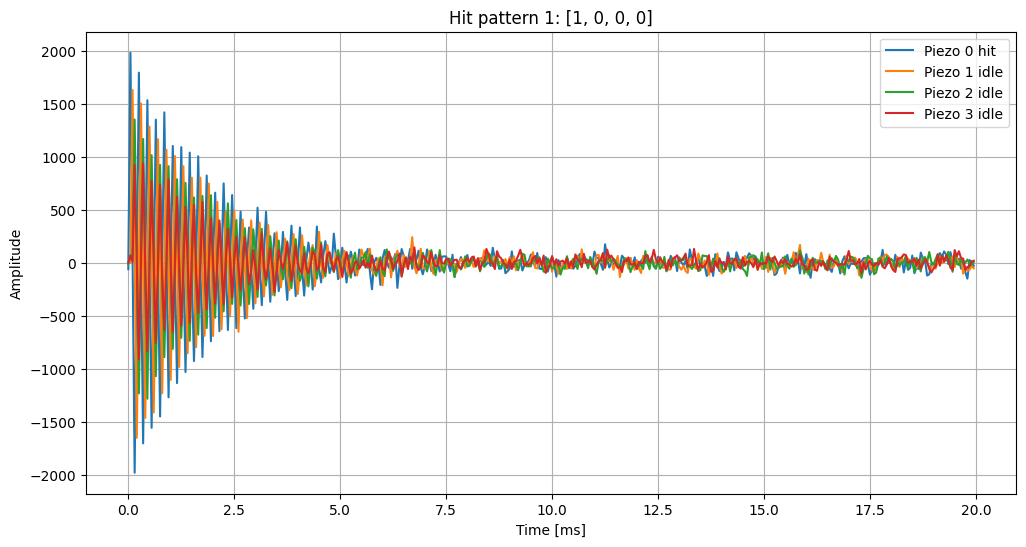

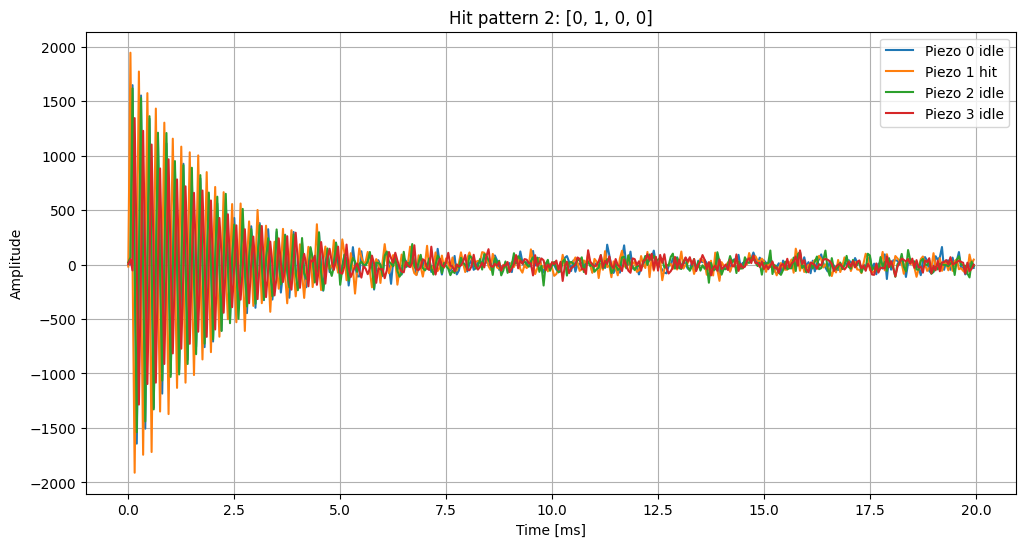

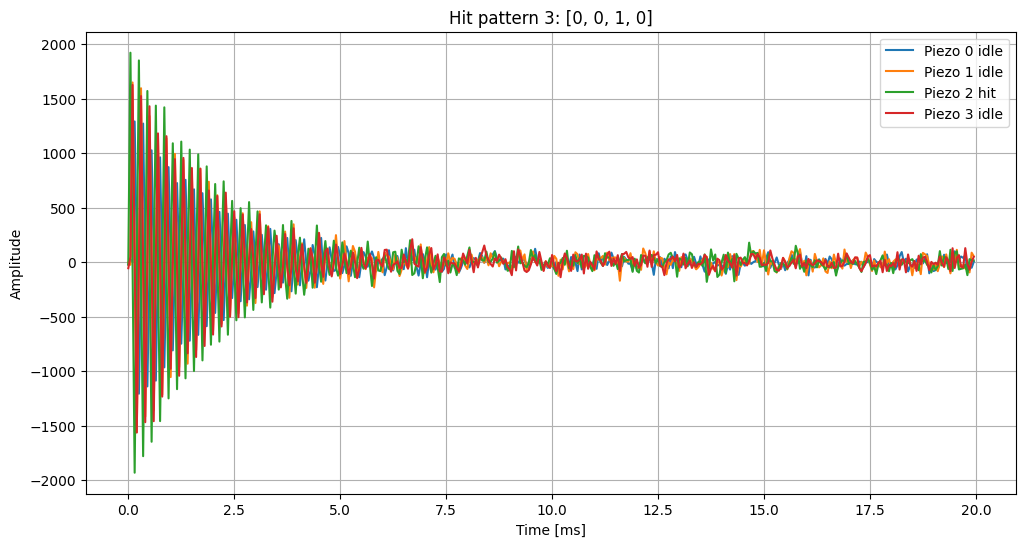

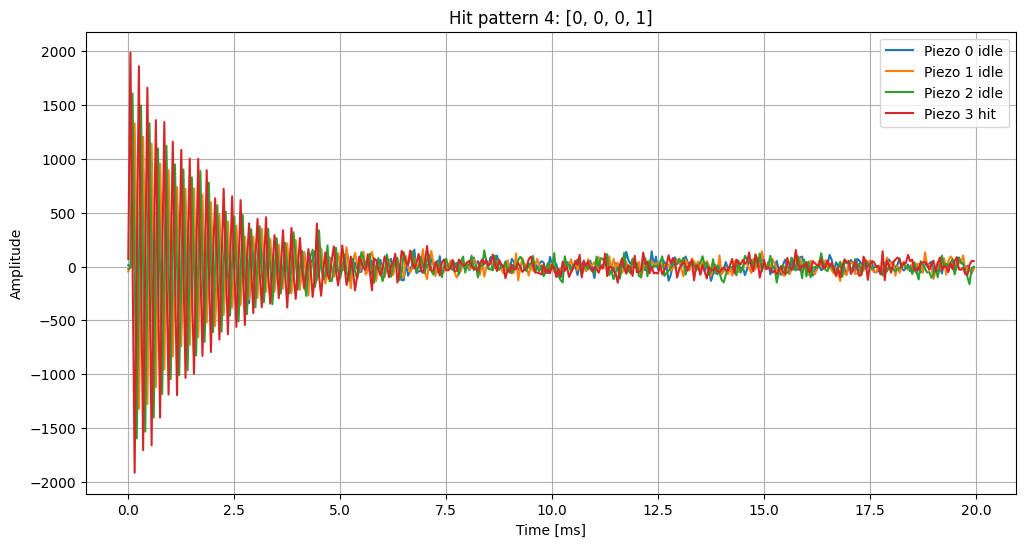

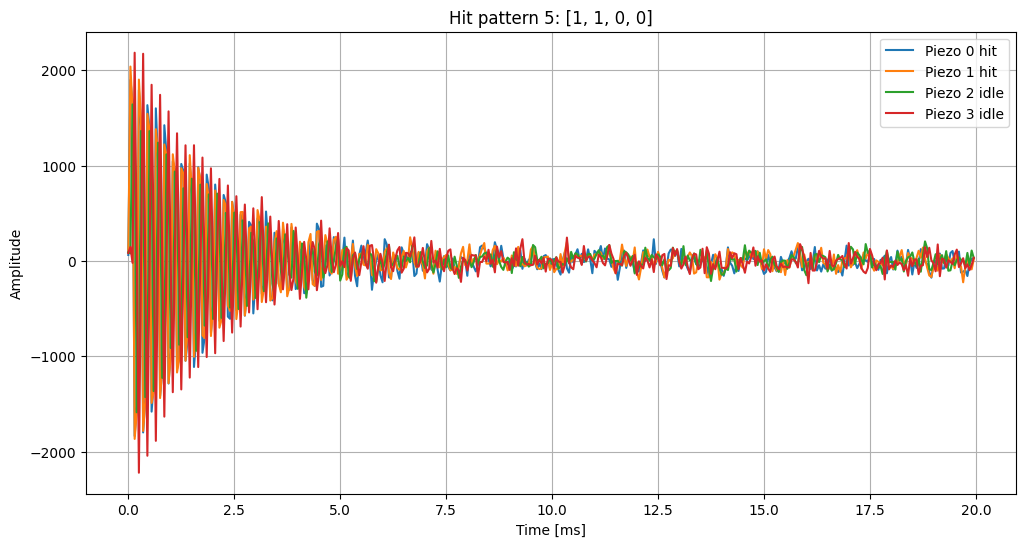

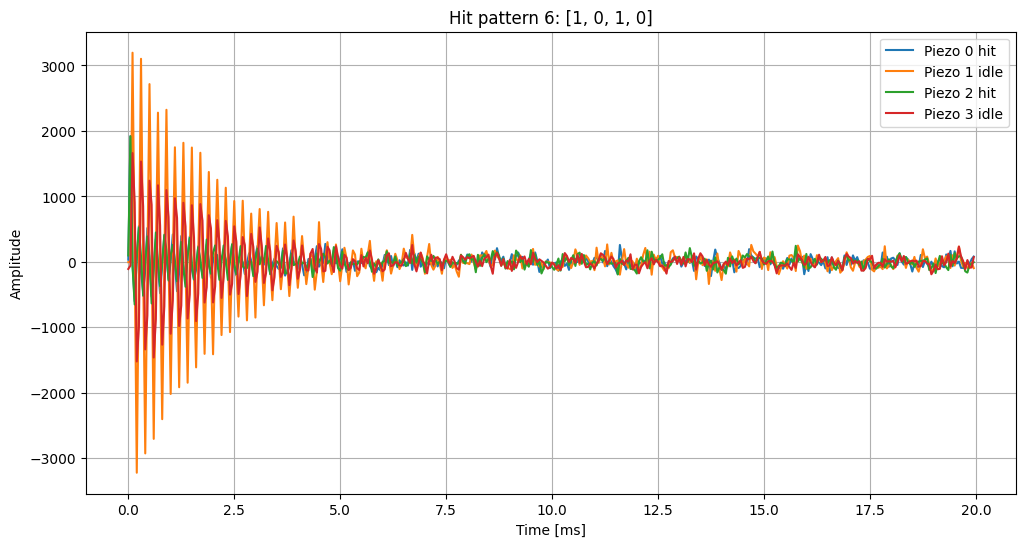

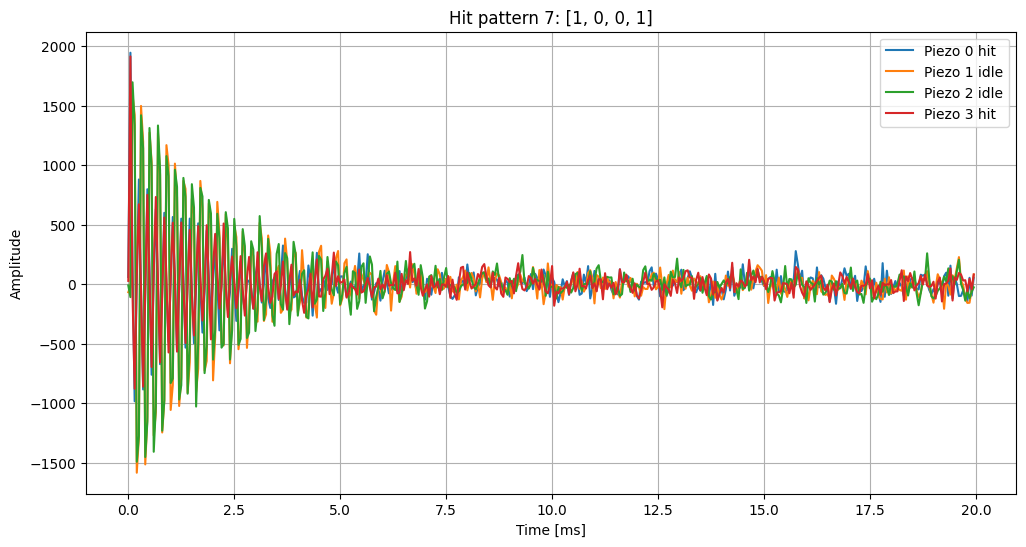

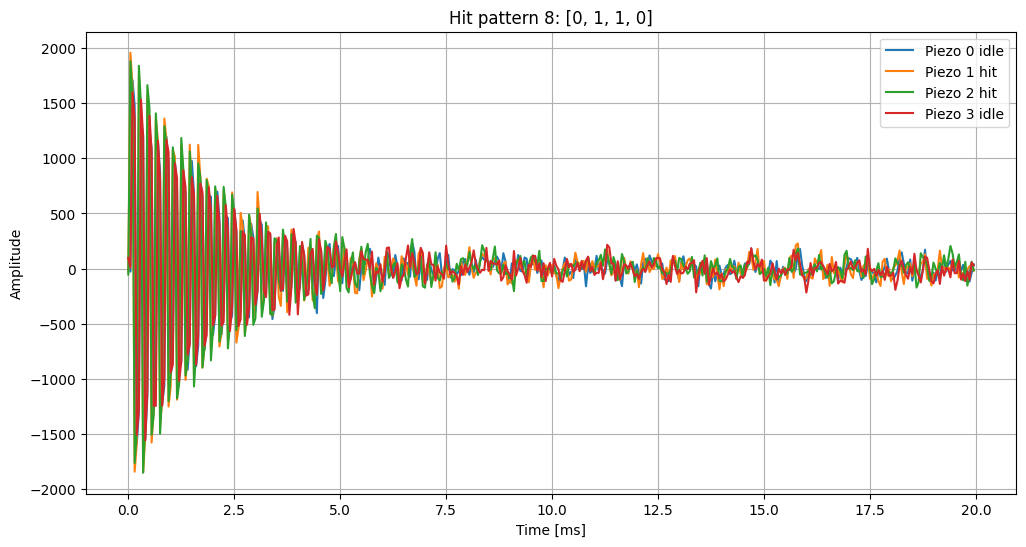

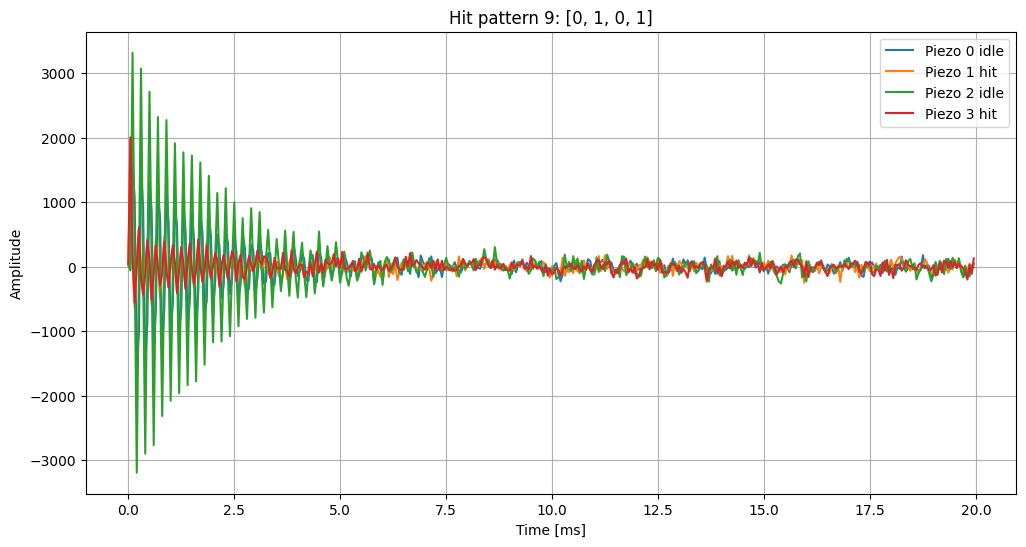

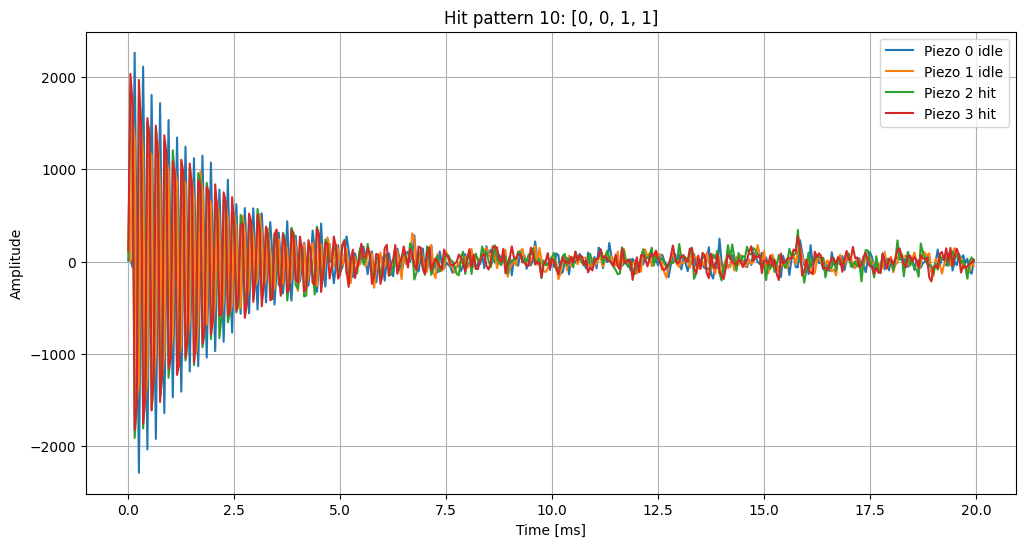

In [18]:
num_piezos = 4          # Taiko drum classic
delta_distance = 0.04   # 4 cm distance between sensors.
wave_speed = 1000       # m/s on drum surface (rough estimate)

# 3D printed structure expects sensors to be placed linearly: 0,1,2,3 with equal spacing.
positions = np.arange(num_piezos) * delta_distance

# Function to compute delay (samples) and scale based on distance
def compute_delay_scale(hit_idx):
    delays = np.zeros(num_piezos, dtype=int)
    scales = np.zeros(num_piezos)
    for i in range(num_piezos):
        dist = abs(positions[i] - positions[hit_idx])
        delays[i] = int(round((dist / wave_speed) * fs))   # delay in samples
        # Expecting linear decay.
        scales[i] = max(0.2, 1 - 0.5 * (dist / (delta_distance*(num_piezos-1))))
        if i == hit_idx:
            scales[i] = 1.0
    return delays, scales

# Generates all valid hit combinations. We only expect up to two sensors to be hit at a time, since we 
# only have two hands to play the drum :)
hit_combinations = []
for r in range(1, 3):
    for combo in itertools.combinations(range(num_piezos), r):
        pattern = [0]*num_piezos
        for idx in combo:
            pattern[idx] = 1
        hit_combinations.append(pattern)

# Simulate signals for each combination
for i, hits in enumerate(hit_combinations):
    signals = np.zeros((num_piezos, N))
    for hit_idx, h in enumerate(hits):
        if h == 0:
            continue
        delays, scales = compute_delay_scale(hit_idx)

        for s in range(num_piezos):
            sig = np.roll(signal, delays[s]) * scales[s]
            sig += noise_level * np.random.randn(N)
            signals[s] += sig
    
    plt.figure(figsize=(12, 6))
    for s in range(num_piezos):
        plt.plot(t*1e3, signals[s], label=f'Piezo {s} {"hit" if hits[s] else "idle"}')
    plt.title(f'Hit pattern {i+1}: {hits}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()

## Solution

Even very noisy signals still come in similar shape by performing small oscillations when piezo is being hit. Since delay between signals is the only way to distinguish different sensors a good delay detection mechanism is required. Cross-correlation is a function of time lag applied to one of the signal, when we expect one of the signal to be the first one.

In frequency domain it can be applied by multiplying two signals, one of which shall be conjugated. The returned IFFT shall provide a proper lag function where the biggest value is expected to be on index corresponding to a time delay that have passed between the two.

Hit pattern 1: [1, 0, 0, 0]
  Delays relative to Piezo 0:
    Piezo 0: 0 samples (self)
    Piezo 1: -1 samples
    Piezo 2: -2 samples
    Piezo 3: -2 samples


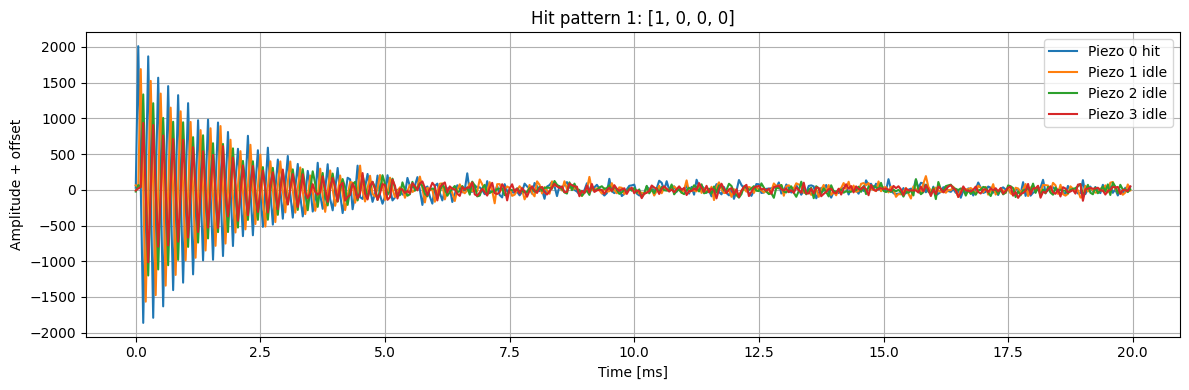

Hit pattern 2: [0, 1, 0, 0]
  Delays relative to Piezo 1:
    Piezo 0: -1 samples
    Piezo 1: 0 samples (self)
    Piezo 2: -1 samples
    Piezo 3: -2 samples


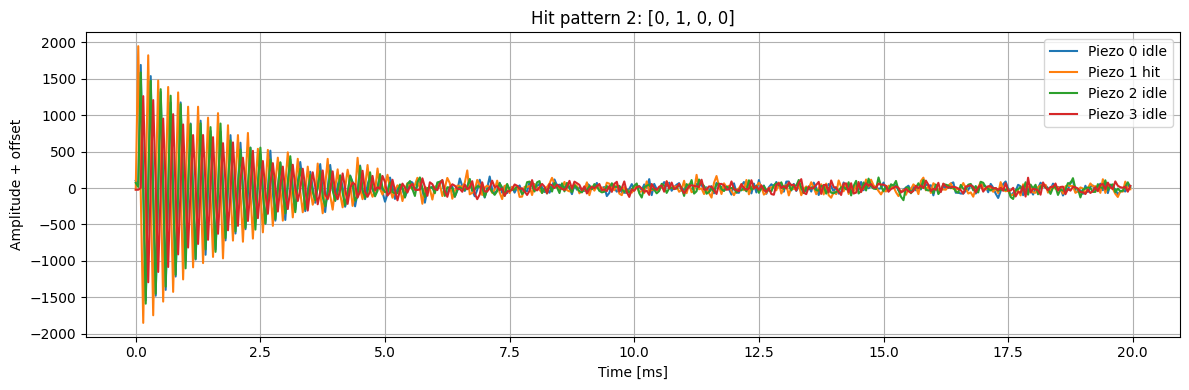

Hit pattern 3: [0, 0, 1, 0]
  Delays relative to Piezo 2:
    Piezo 0: -2 samples
    Piezo 1: -1 samples
    Piezo 2: 0 samples (self)
    Piezo 3: -1 samples


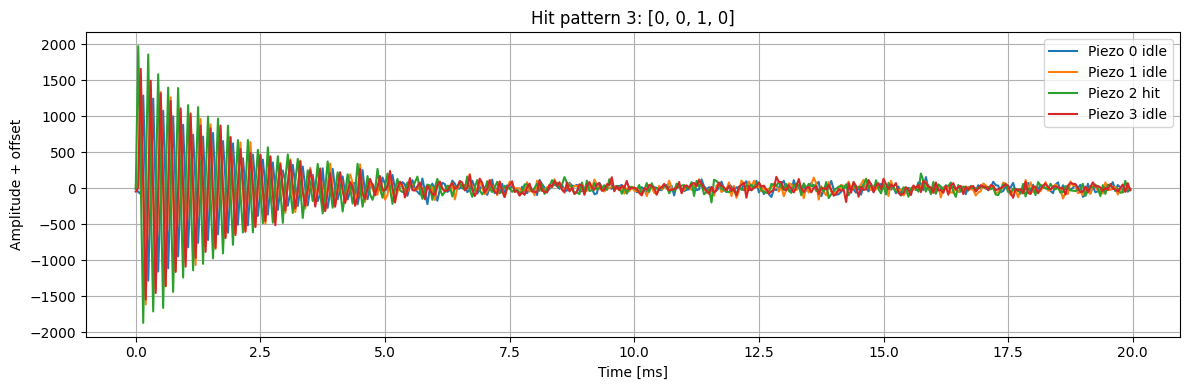

Hit pattern 4: [0, 0, 0, 1]
  Delays relative to Piezo 3:
    Piezo 0: -2 samples
    Piezo 1: -2 samples
    Piezo 2: -1 samples
    Piezo 3: 0 samples (self)


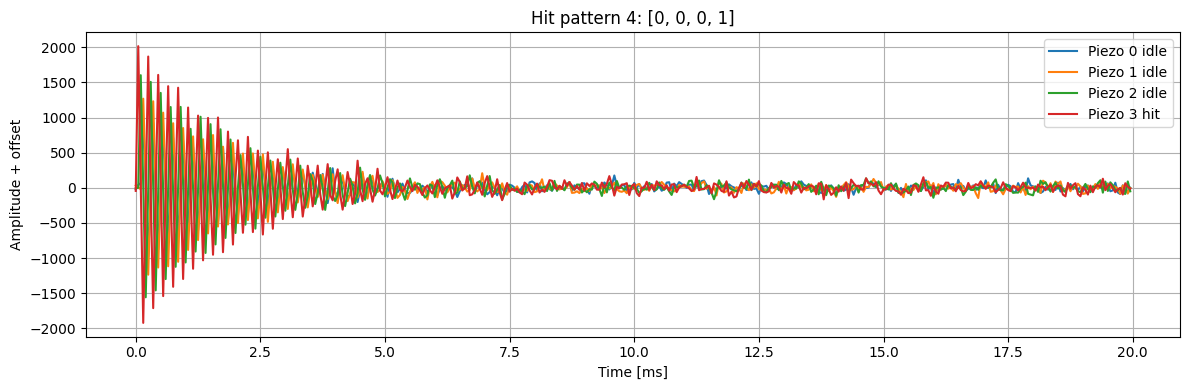

Hit pattern 5: [1, 1, 0, 0]
  Delays relative to Piezo 0:
    Piezo 0: 0 samples (self)
    Piezo 1: 0 samples
    Piezo 2: -1 samples
    Piezo 3: -2 samples
  Delays relative to Piezo 1:
    Piezo 0: 0 samples
    Piezo 1: 0 samples (self)
    Piezo 2: -1 samples
    Piezo 3: -2 samples


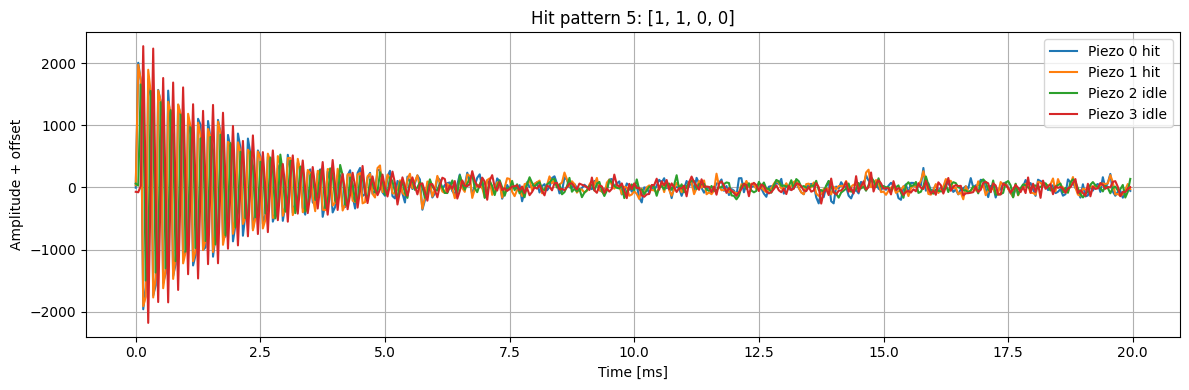

Hit pattern 6: [1, 0, 1, 0]
  Delays relative to Piezo 0:
    Piezo 0: 0 samples (self)
    Piezo 1: -1 samples
    Piezo 2: 0 samples
    Piezo 3: -1 samples
  Delays relative to Piezo 2:
    Piezo 0: 0 samples
    Piezo 1: -1 samples
    Piezo 2: 0 samples (self)
    Piezo 3: -1 samples


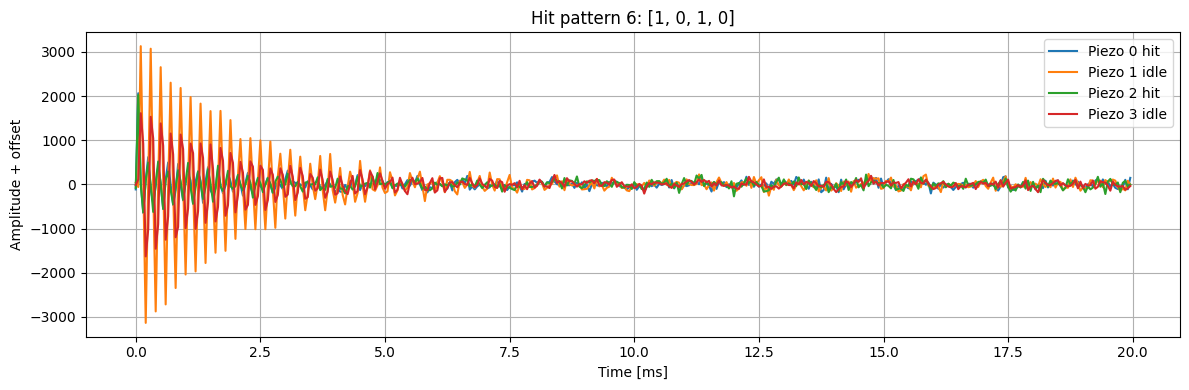

Hit pattern 7: [1, 0, 0, 1]
  Delays relative to Piezo 0:
    Piezo 0: 0 samples (self)
    Piezo 1: -1 samples
    Piezo 2: -1 samples
    Piezo 3: 0 samples
  Delays relative to Piezo 3:
    Piezo 0: 0 samples
    Piezo 1: -1 samples
    Piezo 2: -1 samples
    Piezo 3: 0 samples (self)


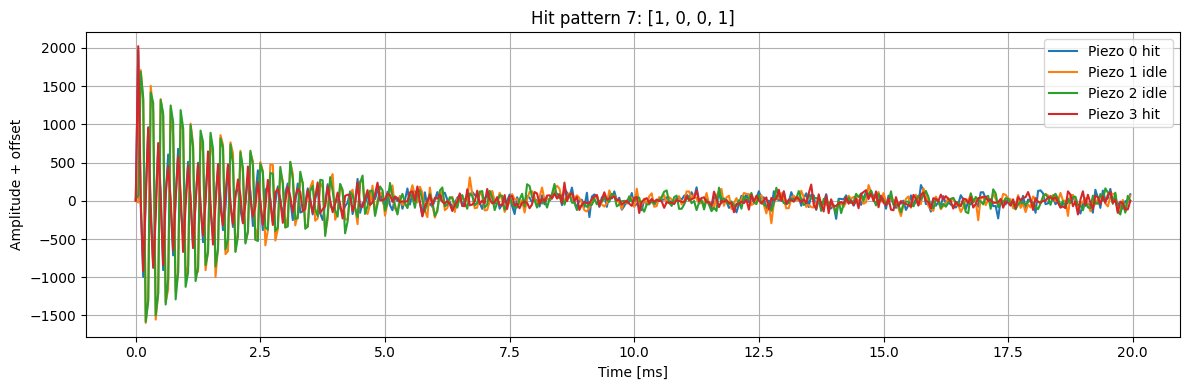

Hit pattern 8: [0, 1, 1, 0]
  Delays relative to Piezo 1:
    Piezo 0: -1 samples
    Piezo 1: 0 samples (self)
    Piezo 2: 0 samples
    Piezo 3: -1 samples
  Delays relative to Piezo 2:
    Piezo 0: -1 samples
    Piezo 1: 0 samples
    Piezo 2: 0 samples (self)
    Piezo 3: -1 samples


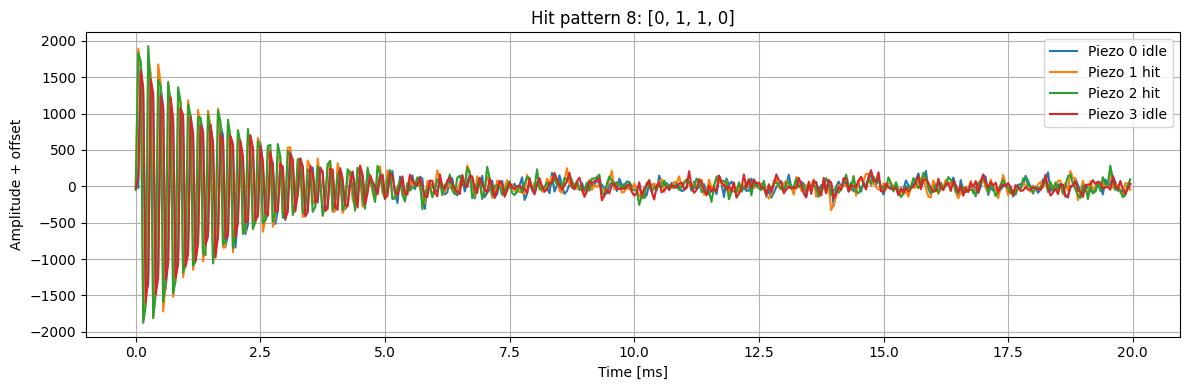

Hit pattern 9: [0, 1, 0, 1]
  Delays relative to Piezo 1:
    Piezo 0: -1 samples
    Piezo 1: 0 samples (self)
    Piezo 2: -1 samples
    Piezo 3: 0 samples
  Delays relative to Piezo 3:
    Piezo 0: -1 samples
    Piezo 1: 0 samples
    Piezo 2: -1 samples
    Piezo 3: 0 samples (self)


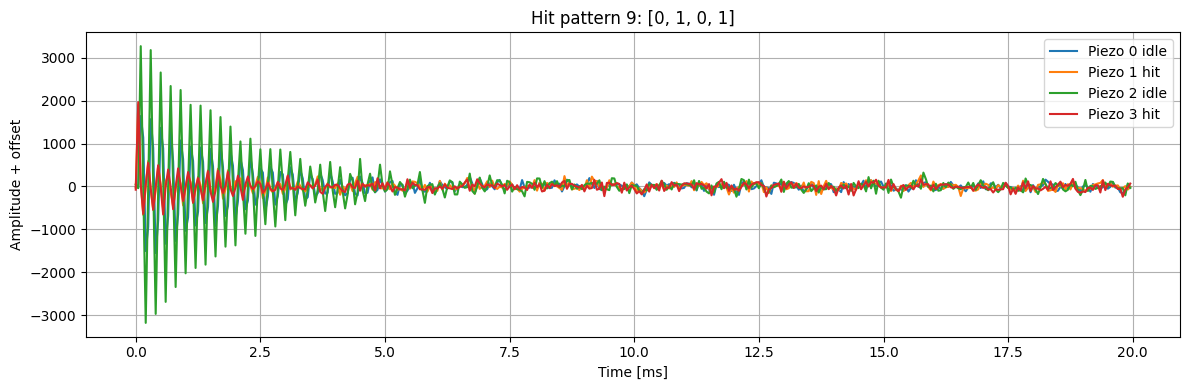

Hit pattern 10: [0, 0, 1, 1]
  Delays relative to Piezo 2:
    Piezo 0: -2 samples
    Piezo 1: -1 samples
    Piezo 2: 0 samples (self)
    Piezo 3: 0 samples
  Delays relative to Piezo 3:
    Piezo 0: -2 samples
    Piezo 1: -1 samples
    Piezo 2: 0 samples
    Piezo 3: 0 samples (self)


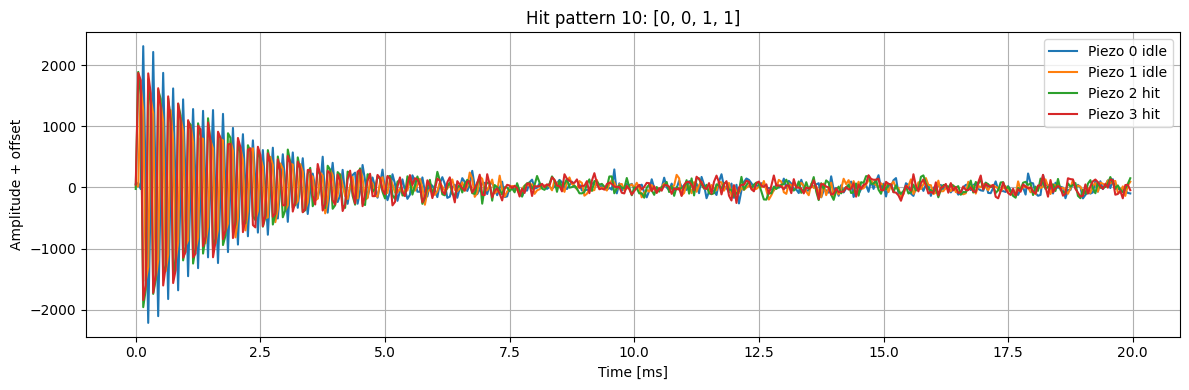

In [22]:
def xcorr(a, b):
    n = len(a)
    # Zero-mean signals to reduce bias
    a = a - np.mean(a)
    b = b - np.mean(b)
    
    # FFTs
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    
    # Frequency domain way to get cross-correlation.
    R = A * np.conj(B)
    r = np.fft.ifft(R).real
    r = np.roll(r, n//2)
    
    return r

for i, hits in enumerate(hit_combinations):
    signals = np.zeros((num_piezos, N))
    
    for hit_idx, h in enumerate(hits):
        if h == 0:
            continue
        delays, scales = compute_delay_scale(hit_idx)
        for s in range(num_piezos):
            sig = np.roll(signal, delays[s]) * scales[s]
            sig += noise_level * np.random.randn(N)
            signals[s] += sig
    
    # Computes delays from hit sensors to all others
    print(f"Hit pattern {i+1}: {hits}")
    for hit_idx, h in enumerate(hits):
        if h == 0:
            continue
        print(f"  Delays relative to Piezo {hit_idx}:")
        for s in range(num_piezos):
            if s == hit_idx:
                print(f"    Piezo {s}: 0 samples (self)")
                continue
            r = xcorr(signals[hit_idx], signals[s])
            lag_idx = np.argmax(r)
            lag = lag_idx - N//2

            print(f"    Piezo {s}: {lag} samples")
    
    plt.figure(figsize=(12, 4))
    for s in range(num_piezos):
        plt.plot(t*1e3, signals[s], label=f'Piezo {s} {"hit" if hits[s] else "idle"}')
    plt.title(f'Hit pattern {i+1}: {hits}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude + offset')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

